In [1]:
import pandas as pd
import numpy as np
import h5py
import deepdish as dd
import multiprocessing as mp

%run -i augergps.py
%matplotlib inline

## 1. Load prepared datasets

In [2]:
hd5file = "data/rouge.ELA2"

dataset = pd.read_hdf(hd5file+"_dataset.hd5")
vtecsum = pd.read_hdf(hd5file+"_vtecsummary.hd5")
rinex_bysat = dd.io.load(hd5file+"_rinex_bysat.hd5")


In [3]:
dataset.head()

,stationid,northing,easting,height,gpstime,secinorbit,b_secinorbit,gpsday,secinday,b_secinday,...,ds_easting,ds_northing,ds_height,d_easting,d_northing,d_height,ds_total,dds_easting,dds_northing,dds_height
13,185,609054618,47087843,139332,1144007478,61158,61140,13240,71478,71460,...,20,-22,8,20,-22,8,30.789609,23,-38,-167
14,185,609054646,47087846,139436,1144007539,61219,61200,13240,71539,71520,...,-28,-15,-91,-28,-15,-91,96.384646,30,3,141
15,185,609054673,47087833,139435,1144007600,61280,61260,13240,71600,71580,...,3,28,104,3,28,104,107.745069,-48,7,-99
16,185,609054670,47087863,139504,1144007660,61340,61320,13240,71660,71640,...,-13,27,-1,-13,27,-1,29.983329,31,43,195
17,185,609054627,47087859,139519,1144007719,61399,61380,13240,71719,71700,...,30,-3,69,30,-3,69,75.299402,-16,-1,-105


## 2. Draw map with IPPs

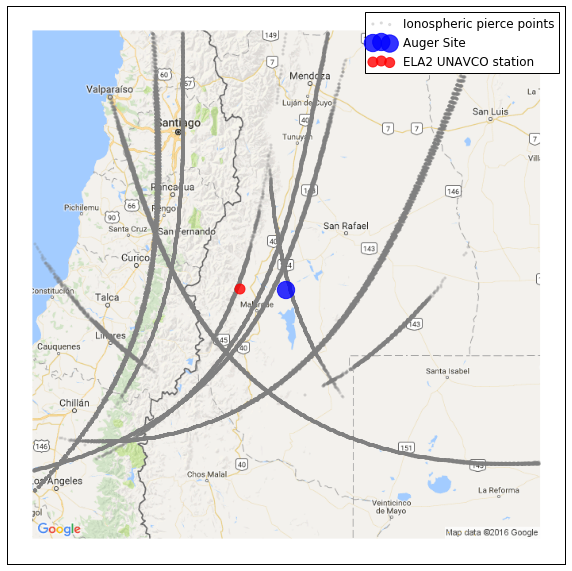

In [6]:
%run -i augergps.py

plt.figure(figsize=(10,10))

centerLat = -35.19
centerLon = -69.17

lats = vtecsum.ipplat_vmax.as_matrix()
lons = vtecsum.ipplon_vmax.as_matrix()
lat_limits, lon_limits, size_x, size_y = plot_inmap(centerLat, centerLon, lats, lons, zoom=7)
ela2_lat, ela2_lon = -35.180170, -69.813670
px, py = latlon_to_pixels(ela2_lat, ela2_lon, lat_limits, lon_limits, size_x, size_y)
plt.scatter(px,py, s=100, alpha=0.8, color="red", label="ELA2 UNAVCO station")
plt.legend()

## 3. Explore periodic behavior

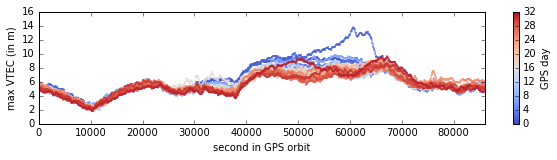

In [8]:
fig = plt.figure(figsize=(10,2))
gpsdays = np.unique(dataset.gpsday)
ndays = len(gpsdays)
cm = plt.get_cmap('coolwarm')

maxday, minday = np.max(gpsdays), np.min(gpsdays)
for i,day in enumerate(gpsdays):
    d = dataset[dataset.gpsday==day]
    sc = plt.scatter(d.secinorbit, d.vmax, s=1,vmin=minday, vmax=maxday, color=cm(i*1./ndays), alpha=0.5)
plt.xlim([np.min(dataset.secinorbit), np.max(dataset.secinorbit)])

import matplotlib.cm as cm
m = cm.ScalarMappable(cmap=plt.get_cmap('coolwarm'))
m.set_array(gpsdays-minday)
cbar = plt.colorbar(m)
cbar.set_label("GPS day")
plt.xlabel("second in GPS orbit")
plt.ylabel("max VTEC (in m)")

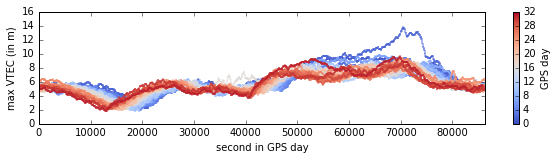

In [117]:
fig = plt.figure(figsize=(10,2))
gpsdays = np.unique(dataset.gpsday)
ndays = len(gpsdays)
cm = plt.get_cmap('coolwarm')

maxday, minday = np.max(gpsdays), np.min(gpsdays)
for i,day in enumerate(gpsdays):
    d = dataset[dataset.gpsday==day]
    sc = plt.scatter(d.secinday, d.vmax, s=1,vmin=minday, vmax=maxday, color=cm(i*1./ndays), alpha=0.5)
plt.xlim([np.min(dataset.secinday), np.max(dataset.secinday)])

import matplotlib.cm as cm
m = cm.ScalarMappable(cmap=plt.get_cmap('coolwarm'))
m.set_array(gpsdays-minday)
cbar = plt.colorbar(m)
cbar.set_label("GPS day")
plt.xlabel("second in GPS day")
plt.ylabel("max VTEC (in m)")

## 4. Define column sets

In [ ]:
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import StandardScaler


input_columns_diffs = ["ds_height", "ds_northing", "ds_easting",
                       "dds_height", "dds_northing", "dds_easting","ds_total",
                       "secinorbit", "secinday"] 

input_columns_all = ["s_height", "s_northing", "s_easting", 
                     "ds_height", "ds_northing", "ds_easting",
                     "ds_total",
                     "dds_height", "dds_northing", "dds_easting",
                     "secinorbit", "secinday"] 

input_columns_time = ["secinorbit", "secinday"] 
predict_column = "vmax"

## 5. Run experiments
### BayesianRidge A. Increasing power transformations



In [11]:
from sklearn.linear_model import Lasso, BayesianRidge
roots = [2.51351256281, 2.01101005025, 1.25725628141, 0.001, 50.0, 6.28228140704, 0.503502512563]
roots = np.linspace(.001,.9,10)
roots = []
estimator = BayesianRidge()
n_powers = [0,2,4,6,8,10,12,14,16,18]
br1_diffs = [get_cv_score(dataset, estimator, 20, 1, input_columns_diffs, predict_column, 
                  polynomial_expand(powers = range(1,i), roots = roots, no_pca=True ), 
                  n_jobs=20) for i in n_powers]
print 
br1_all = [get_cv_score(dataset, estimator, 20, 1, input_columns_all, predict_column, 
                  polynomial_expand(powers = range(1,i), roots = roots, no_pca=True ), 
                  n_jobs=20) for i in n_powers]
print
br1_time = [get_cv_score(dataset, estimator, 20, 1, input_columns_time, predict_column, 
                  polynomial_expand(powers = range(1,i), roots = roots, no_pca=True ), 
                  n_jobs=20) for i in n_powers]

. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .


### BayesianRidge B. Increasing number of train days

In [14]:
%run -i augergps.py
from sklearn.linear_model import Lasso, BayesianRidge, LinearRegression
roots = np.linspace(.001,.9,10)
n_days = range(4,25,2)
estimator = BayesianRidge()
br2_diffs = [get_cv_score(dataset, BayesianRidge(), 
                  i, 1, input_columns_diffs, predict_column, 
                  polynomial_expand(roots=roots, powers=range(1,14), no_pca=True), 
                  n_jobs=20) for i in n_days]
print
br2_all = [get_cv_score(dataset, BayesianRidge(), 
                  i, 1, input_columns_all, predict_column, 
                  polynomial_expand(roots=roots, powers=range(1,14), no_pca=True), 
                  n_jobs=20) for i in n_days]
print
br2_time = [get_cv_score(dataset, BayesianRidge(), 
                  i, 1, input_columns_time, predict_column, 
                  polynomial_expand(roots=roots, powers=range(1,14), no_pca=True), 
                  n_jobs=20) for i in n_days]

. . . . . . . . . . .
. . . . . . . . . . .
. . . . . . . . . . .


### RandomForest A. Increasing number of estimators


In [17]:
from sklearn.linear_model import Lasso, BayesianRidge
estimator = RandomForestRegressor()
n_estimators = [1,5,10,15,20,25]
rf2_diffs = [get_cv_score(dataset, RandomForestRegressor(n_estimators=i), 
                  20, 1, input_columns_diffs, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in n_estimators]
print
rf2_all = [get_cv_score(dataset, RandomForestRegressor(n_estimators=i), 
                  20, 1, input_columns_all, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in n_estimators]
print
rf2_time = [get_cv_score(dataset, RandomForestRegressor(n_estimators=i), 
                  20, 1, input_columns_time, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in n_estimators]

. . . . . .
. . . . . .
. . . . . .


### RandomForest B. Increasing number of powers


In [19]:
from sklearn.linear_model import Lasso, BayesianRidge, LinearRegression
estimator = RandomForestRegressor()
roots = np.linspace(.001,.9,10)
n_powers_r = [0,5,10,15,20,30,40,50,60]

estimator = RandomForestRegressor()
rf3_diffs = [get_cv_score(dataset, RandomForestRegressor(n_estimators=10), 
                  20, 1, input_columns_diffs, predict_column, 
                  polynomial_expand(roots=roots, powers = range(1,i), no_pca=True), 
                  n_jobs=20) for i in n_powers_r]
rf3_all = [get_cv_score(dataset, RandomForestRegressor(n_estimators=10), 
                  20, 1, input_columns_all, predict_column, 
                  polynomial_expand(roots=roots, powers = range(1,i), no_pca=True), 
                  n_jobs=20) for i in n_powers_r]
rf3_time = [get_cv_score(dataset, RandomForestRegressor(n_estimators=10), 
                  20, 1, input_columns_time, predict_column, 
                  polynomial_expand(roots=roots, powers = range(1,i), no_pca=True), 
                  n_jobs=20) for i in n_powers_r]

. . . . . . . . . . . . . . . . . . . . . . . . . . .


### RandomForest C. Increasing number of train days


In [24]:
%run -i augergps.py
from sklearn.linear_model import Lasso, BayesianRidge, LinearRegression
estimator = RandomForestRegressor()
n_days = range(4,25,2)
estimator = RandomForestRegressor()
rf4_diffs = [get_cv_score(dataset, RandomForestRegressor(n_estimators=10), 
                  i, 1, input_columns_diffs, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in n_days]
print
rf4_all = [get_cv_score(dataset, RandomForestRegressor(n_estimators=10), 
                  i, 1, input_columns_all, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in n_days]
print
rf4_time = [get_cv_score(dataset, RandomForestRegressor(n_estimators=10), 
                  i, 1, input_columns_time, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in n_days]

. . . . . . . . . . .
. . . . . . . . . . .
. . . . . . . . . . .


### SVR A. Increasing gamma


In [26]:
from  sklearn.svm import SVR
gammas = [.01,.1,.5, 1.,1.5, 2.,3.,4.,5.]


svr1_diffs = [get_cv_score(dataset, SVR(gamma=i), 
                  20, 1, input_columns_diffs, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in gammas]
print

svr1_all = [get_cv_score(dataset, SVR(gamma=i), 
                  20, 1, input_columns_all, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in gammas]
print
svr1_time = [get_cv_score(dataset, SVR(gamma=i), 
                  20, 1, input_columns_time, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in gammas]


. . . . . . . . .
. . . . . . . . .
. . . . . . . . .


### SVR B. Increasing C


In [28]:
from  sklearn.svm import SVR
Cs = [.01,.1,.5, 1.,1.5, 2.,3.]


svr3_diffs = [get_cv_score(dataset, SVR(gamma=2., C=i), 
                  20, 1, input_columns_diffs, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in Cs]
print

svr3_all = [get_cv_score(dataset, SVR(gamma=2., C=i), 
                  20, 1, input_columns_all, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in Cs]
print
svr3_time = [get_cv_score(dataset, SVR(gamma=2., C=i), 
                  20, 1, input_columns_time, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in Cs]


. . . . . . .
. . . . . . .
. . . . . . .


### SVR C. Increasing number of train days


In [30]:
%run -i augergps.py
from sklearn.linear_model import Lasso, BayesianRidge, LinearRegression
estimator = RandomForestRegressor()
n_days = range(4,25,2)

svr2_diffs = [get_cv_score(dataset, SVR(gamma=2.), 
                  i, 1, input_columns_diffs, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in n_days]
print
svr2_all = [get_cv_score(dataset, SVR(gamma=2.), 
                  i, 1, input_columns_all, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in n_days]
print
svr2_time = [get_cv_score(dataset, SVR(gamma=2.), 
                  i, 1, input_columns_time, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in n_days]

. . . . . . . . . . .
. . . . . . . . . . .
. . . . . . . . . . .


### LASSO A. Increasing alphas

In [33]:
%run -i augergps.py
from sklearn.linear_model import Lasso
ls_alphas = [1e-3,1e-2,1e-1,1,10,100]
ls1_diffs = [get_cv_score(dataset, Lasso(alpha=i), 
                  20, 1, input_columns_diffs, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in ls_alphas]
print
ls1_all = [get_cv_score(dataset, Lasso(alpha=i),
                  20, 1, input_columns_all, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in ls_alphas]
print
ls1_time = [get_cv_score(dataset, Lasso(alpha=i),
                  20, 1, input_columns_time, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in ls_alphas]

. . . . . .
. . . . . .
. . . . . .


### LASSO B. Increasing number of train days


In [38]:
%run -i augergps.py
n_days = range(4,25,2)

from sklearn.linear_model import Lasso, BayesianRidge, LinearRegression, Ridge, ElasticNet, LassoLars
ls2_diffs = [get_cv_score(dataset, Lasso(alpha=1e-3), 
                  20, 1, input_columns_diffs, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in n_days]
print
ls2_all = [get_cv_score(dataset, Lasso(alpha=1e-3),
                  20, 1, input_columns_all, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in n_days]
print
ls2_time = [get_cv_score(dataset, Lasso(alpha=1e-3),
                  20, 1, input_columns_time, predict_column, 
                  polynomial_expand(no_pca=True), 
                  n_jobs=20) for i in n_days]

. . . . . . . . . . .
. . . . . . . . . . .
. . . . . . . . . . .


### PLOT ALL RESULTS

In [36]:
def plot_comparison(title, xaxis, diffs, alls, times, xlabel=None, scale=None):
    means0, means1, means2 = np.array([i[0] for i in diffs]), np.array([i[0] for i in alls]), np.array([i[0] for i in times])
    stds0, stds1, stds2   = np.array([i[1] for i in diffs]), np.array([i[1] for i in alls]), np.array([i[1] for i in times])
    plt.plot(xaxis, means0, label="diffs")
    plt.plot(xaxis, means1, label="all")
    plt.plot(xaxis, means2, label="times")
    plt.xlim( [np.min(xaxis), np.max(xaxis)])
    if xlabel is not None:
        plt.xlabel(xlabel)
    if scale is not None:
        plt.xscale(scale)
    if title is not None:
        plt.title(title)

### all plots together

number of estimators
gamma
number of powers
alpha


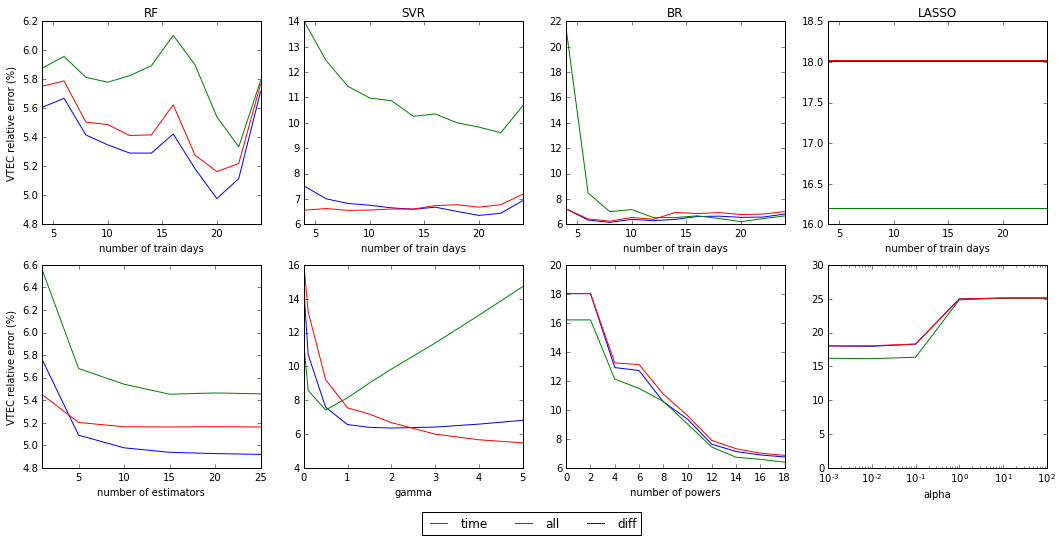

In [42]:
data = {}
data["BR"] = [ {"xlabel":"number of train days", "x": n_days, "diffs": br2_diffs, "all": br2_all, "time":br2_time}, 
               {"xlabel":"number of powers", "x": n_powers,    "diffs": br1_diffs, "all": br1_all, "time": br1_time}]

data["RF"] = [{"xlabel":"number of train days","x": n_days, "diffs": rf4_diffs, "all": rf4_all, "time": rf4_time}, 
              {"xlabel": "number of estimators", "x": n_estimators,"diffs": rf2_diffs, "all": rf2_all, "time": rf2_time}]

data["SVR"] = [{"xlabel":"number of train days","x": n_days, "diffs": svr2_diffs, "all": svr2_all, "time": svr2_time}, 
              {"xlabel": "gamma", "x": gammas,"diffs": svr1_diffs, "all": svr1_all, "time": svr1_time}]

data["LASSO"] = [{"xlabel":"number of train days","x": n_days, "diffs": ls2_diffs, "all": ls2_all, "time": ls2_time}, 
                 {"xlabel": "alpha", "x": ls_alphas,"diffs": ls1_diffs, "all": ls1_all, "time": ls1_time}]

estimator = "RF"

fig = plt.figure(figsize=(18,8))
lk = len(data.keys())
for i, estimator in enumerate(data.keys()):
    scale = "log" if estimator=="LASSO" else None
    fig.add_subplot(2,lk, i+1)
    d = data[estimator][0]
    plot_comparison(estimator, d["x"], d["diffs"], d["all"], d["time"], d["xlabel"])
    if i==0:
        plt.ylabel("VTEC relative error (%)")
    
    fig.add_subplot(2,lk, lk+i+1)
    d = data[estimator][1]
    print d["xlabel"]
    plot_comparison(None, d["x"], d["diffs"], d["all"], d["time"], d["xlabel"], scale=scale)    
    if i==0:
        plt.ylabel("VTEC relative error (%)")
p1, = plt.plot([0,0],[1,1], color="red")
p2, = plt.plot([0,0],[1,1], color="green")
p3, = plt.plot([0,0],[1,1,], color="blue")
fig.legend((p1, p2, p3), ('time', 'all', 'diff'),  loc = 'lower center', ncol=5, labelspacing=0.)



### SUMMARY TABLE

In [68]:
for k in data.keys():
    r = []
    for j in range(2):
        m1 = np.array([i[0] for i in data[k][j]["diffs"]])
        m2 = np.array([i[0] for i in data[k][j]["all"]])
        m3 = np.array([i[0] for i in data[k][j]["time"]])

        r.append([data[k][j]["xlabel"], np.mean(m3-m1), np.mean(m3-m2), np.min(m1), np.min(m2), np.min(m3)])

    r = np.array(r)
    print k
    print pd.DataFrame(r[:,1:], index=r[:,0], columns=["MEAN DIFFS vs TIME", "MEAN ALL vs TIME", "BEST DIFF", 
                                                       "BEST ALL", "BEST TIME"])
    

RF
                     MEAN DIFFS vs TIME MEAN ALL vs TIME      BEST DIFF  \
number of train days     0.125386331495   -0.30926331791   4.9772963583   
number of estimators     0.115768233019  -0.474536114035  4.91904010958   

                           BEST ALL      BEST TIME  
number of train days  5.33472396571  5.16390786819  
number of estimators  5.45288941419  5.16226877893  
SVR
                     MEAN DIFFS vs TIME MEAN ALL vs TIME      BEST DIFF  \
number of train days   -0.0542045400679   -4.25736183448  6.35105095973   
gamma                    0.573924527154   -1.81995313432  6.35105095973   

                           BEST ALL      BEST TIME  
number of train days  9.60710809714  6.54926982684  
gamma                 7.41830348634  5.47821482427  
BR
                     MEAN DIFFS vs TIME MEAN ALL vs TIME      BEST DIFF  \
number of train days     0.196186908751   -1.39987604378  6.15518273962   
number of powers         0.218880640338   0.940524301854  6.7491657288

## 6. Illustrate prediction

summary DIFF
TRAIN DATA: (27949, 9) data points     TEST DATA: (12960, 9) data points
      from: 2016-04-07 19:51:05       from: 2016-04-27 19:51:03
        to: 2016-04-27 19:50:03         to: 2016-05-06 19:50:04
train prediction error 2.06%
 test prediction error 5.87%
summary TIME
TRAIN DATA: (27949, 2) data points     TEST DATA: (12960, 2) data points
      from: 2016-04-07 19:51:05       from: 2016-04-27 19:51:03
        to: 2016-04-27 19:50:03         to: 2016-05-06 19:50:04
train prediction error 2.07%
 test prediction error 6.50%


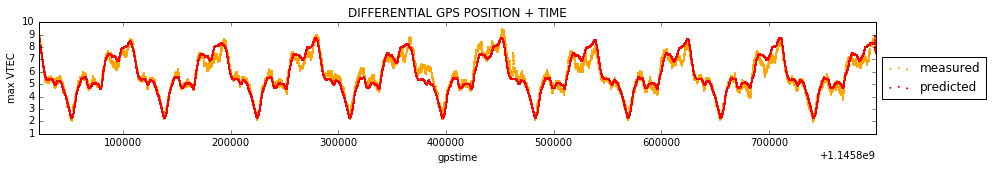

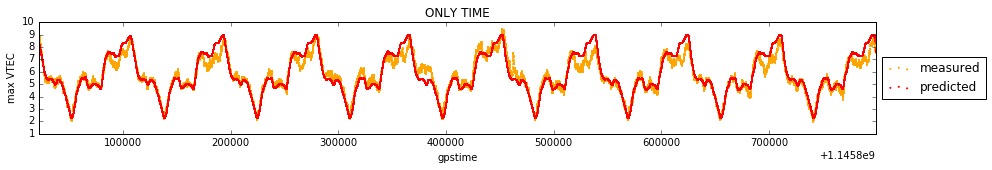

In [160]:
%run -i augergps.py

train_days, test_days = range(1,21), range(21,30)
estimator = RandomForestRegressor(n_estimators=20)
pe        = polynomial_expand(no_pca=True)

print "summary DIFF"
ytrain_error, ytest_error, ctrain, ctest = build_NEH_model(dataset, input_columns_diffs, predict_column, 
                                                                    train_days,test_days, 
                                                                    estimator, pe)
show_pred(estimator, ctest, input_columns_diffs, predict_column, pe, title="DIFFERENTIAL GPS POSITION + TIME", dofig=True)
print "summary TIME"
ytrain_error, ytest_error, ctrain, ctest = build_NEH_model(dataset, input_columns_time, predict_column, 
                                                                    train_days,test_days, 
                                                                    estimator, pe)
show_pred(estimator, ctest, input_columns_time, predict_column, pe, title="ONLY TIME", dofig=True)

## Extra. Correlations with vmax

In [161]:
from sklearn.preprocessing import StandardScaler
dd = dataset[input_columns_all + ["vmax"]]
dd=pd.DataFrame(StandardScaler().fit_transform(dd), columns=dd.columns)
#scatter_matrix(dd, alpha=0.2, figsize=(15,15));
#dd.join(pd.DataFrame(dd["ds_height"]*dd["ds_northing"], columns=["new"]), ignore_index=True)
cols = input_columns_all + ["vmax"]
original_corrs = (dd[cols[:-1]]).join(dd[cols[-1]]).corr().vmax
original_corrs

s_height       -0.174353
s_northing     -0.595751
s_easting      -0.028580
ds_height      -0.001704
ds_northing    -0.000004
ds_easting      0.010249
ds_total        0.054375
dds_height      0.000308
dds_northing    0.000956
dds_easting     0.000304
secinorbit      0.515361
secinday        0.614480
vmax            1.000000
Name: vmax, dtype: float64